Index(['Wavelength', 'Intensity', 'Spectrum_ID'], dtype='object')
Index(['Wavelength', 'Intensity', 'Spectrum_ID'], dtype='object')


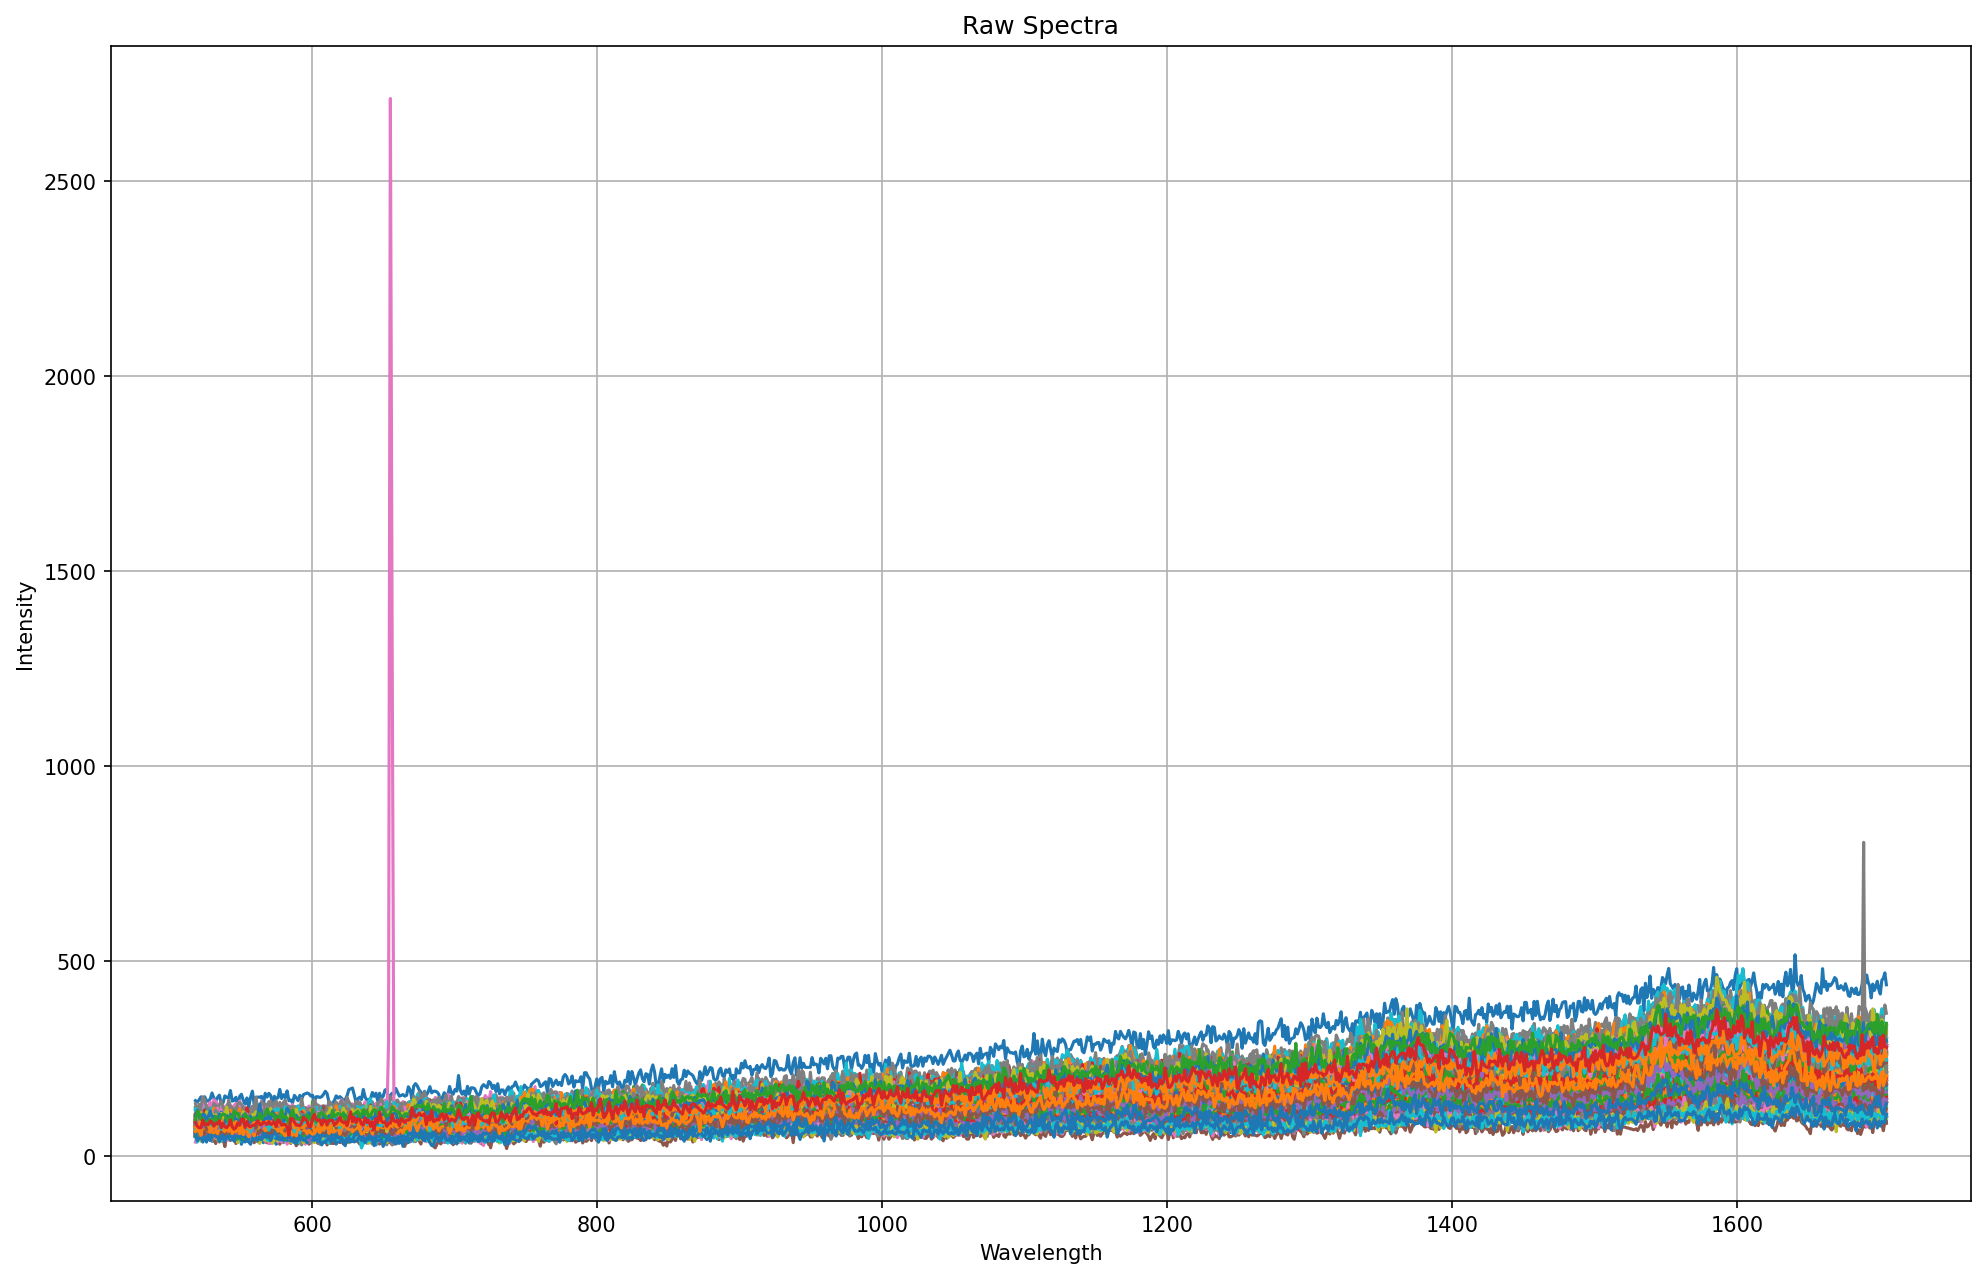

In [1]:
# 1) LOAD & PREPROCESS DATA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv("/kaggle/input/malariaclean/malaria.csv")

# Find indices where Raman shift is repeated
split_indices = np.where(data['Wavelength'] == 1705.003906)[0]

# Create a list to store each spectrum
spectra = []

# Create a copy of DataFrame before iteration process
data_copy = data.copy()

# Iterate through split indices to separate spectra
for i in range(len(split_indices)):
    if i == 0:
        spectrum = data_copy.iloc[:split_indices[i]].copy()
    else:
        spectrum = data_copy.iloc[split_indices[i-1]:split_indices[i]].copy()
    # Reset index of spectrum DataFrame
    spectrum.reset_index(drop=True, inplace=True)
     
    # Add 'Spectrum_ID' column
    spectrum['Spectrum_ID'] = i + 1
    
    # Append spectrum to list
    spectra.append(spectrum)
    
# Concatenate all spectra DataFrames into one (ignoring index to preserve column names)
all_spectra_id = pd.concat(spectra, ignore_index=True)

# Save to a single file
all_spectra_id.to_csv("all_spectra_id.csv", index=False)

# Check columns of DataFrame
print(all_spectra_id.columns)
print(spectrum.columns)

# Plot
plt.figure(figsize=(16, 10), dpi=150)

for spectrum_id in all_spectra_id['Spectrum_ID'].unique():
    spectrum_data = all_spectra_id[all_spectra_id['Spectrum_ID'] == spectrum_id]
    plt.plot(spectrum_data['Wavelength'], spectrum_data['Intensity'], label=f'Spectrum {spectrum_id}')

plt.xlabel('Wavelength')
plt.ylabel('Intensity')
plt.title('Raw Spectra')
plt.grid(True)
plt.show()

  Spectrum_ID   Wavelength  Corrected_Intensity
0  Spectrum_1  1705.003906             1.007219
1  Spectrum_1  1703.941406             0.000000
2  Spectrum_1  1702.878906             1.931192
3  Spectrum_1  1701.816406             0.000000
4  Spectrum_1  1700.753906             2.869620


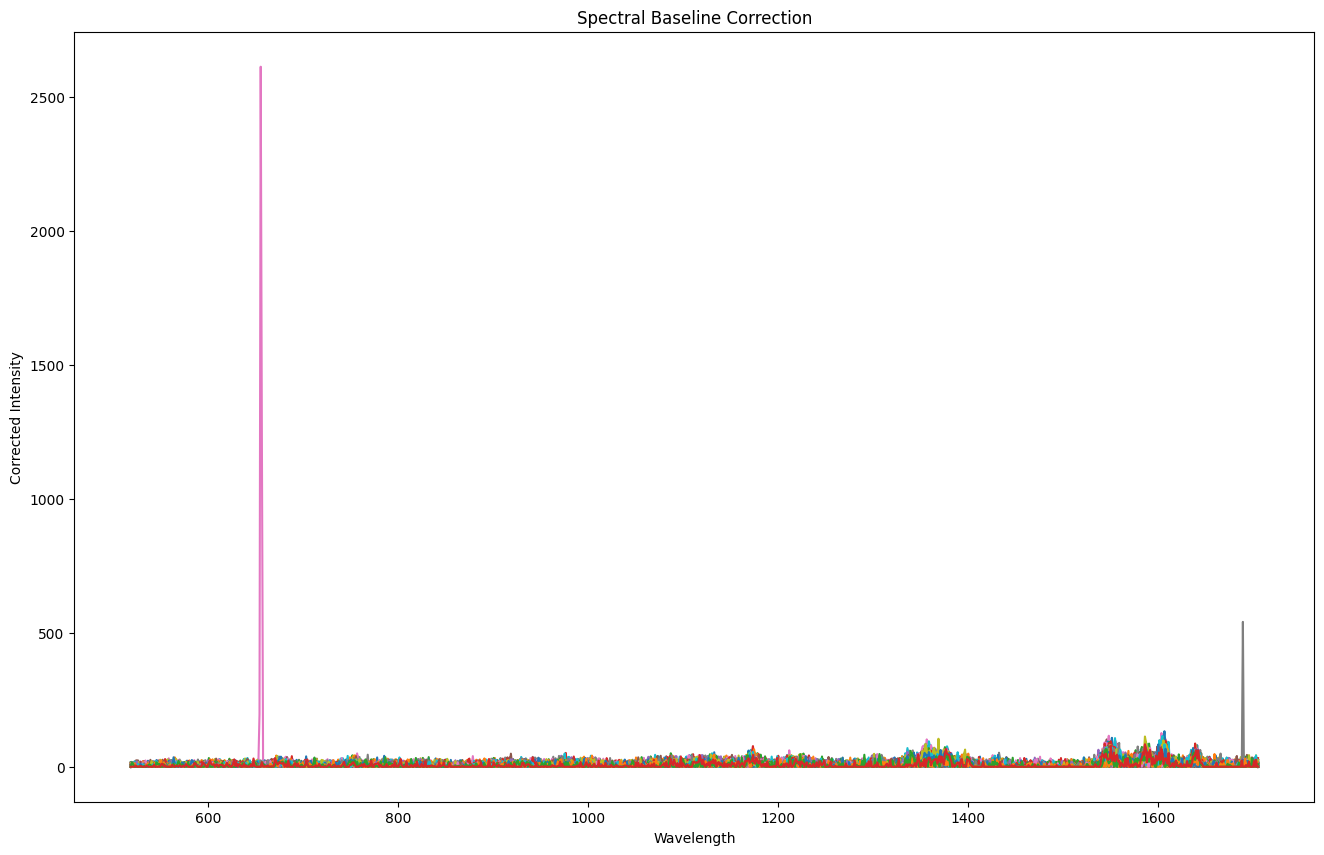

In [2]:
# 2) BASELINE CORRECTION (REMOVING NEGATIVE VALUES - ZERO APPROACH)
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define baseline correction function
def raman_baseline_correction(wavenumbers, spectrum, polynomial_order):
    def chebyshev_polynomial(x, *coefficients):
        return np.polynomial.chebyshev.chebval(x, coefficients)

    # Fit Chebyshev polynomial to entire spectrum
    baseline_coefficients, _ = curve_fit(chebyshev_polynomial, wavenumbers, spectrum, p0=np.zeros(polynomial_order + 1))

    # Subtract fitted polynomial from original spectrum
    corrected_baseline = spectrum - chebyshev_polynomial(wavenumbers, *baseline_coefficients)

    return baseline_coefficients, corrected_baseline 

# Load data
df = pd.read_csv('all_spectra_id.csv')

# Initialize an empty list to store DataFrames
dfs = []

# Initialize a counter for generating unique IDs
id_counter = 1

# Perform baseline correction & append to list
for Spectrum_ID in df['Spectrum_ID'].unique():
    # Extract relevant data for current spectrum
    wavenumbers_spectrum = df[df['Spectrum_ID'] == Spectrum_ID]['Wavelength']
    intensity_spectrum = df[df['Spectrum_ID'] == Spectrum_ID]['Intensity']
    
    # Check if data is not empty
    if wavenumbers_spectrum.empty or intensity_spectrum.empty:
        print(f"No data found for spectrum ID: {Spectrum_ID}")
        continue

    # Perform baseline correction for current spectrum
    polynomial_order_spectrum = 5
    baseline_coefficients_spectrum, corrected_baseline_spectrum = raman_baseline_correction(wavenumbers_spectrum, intensity_spectrum, polynomial_order_spectrum)

    # Ensure corrected intensity is non-negative
    corrected_baseline_spectrum = np.maximum(corrected_baseline_spectrum, 0)
    
    # Generate a unique ID for each spectrum
    spectrum_id = f'Spectrum_{id_counter}'
    id_counter += 1

    # Add Spectrum_ID column back to corrected DataFrame
    corrected_baseline_df = pd.DataFrame({'Spectrum_ID': spectrum_id, 'Wavelength': wavenumbers_spectrum, 'Corrected_Intensity': corrected_baseline_spectrum})
    
    # Reorganize columns
    corrected_baseline_df = corrected_baseline_df[['Spectrum_ID', 'Wavelength', 'Corrected_Intensity']]

    # Append corrected spectrum DataFrame to the list
    dfs.append(corrected_baseline_df)

# Concatenate all DataFrames into a single
combined_df = pd.concat(dfs, ignore_index=True)

# Save combined DataFrame in one file
combined_df.to_csv("combined_file.csv", index=False)

# Print first few rows
print(combined_df.head())

# Plot
plt.figure(figsize=(16, 10), dpi=100)

num_spectra_to_plot = 135 
for spectrum_id in combined_df['Spectrum_ID'].unique()[:num_spectra_to_plot]:
    # Extract data for current spectrum
    spectrum_data = combined_df[combined_df['Spectrum_ID'] == spectrum_id]
    wavenumbers = spectrum_data['Wavelength']
    corrected_intensity = spectrum_data['Corrected_Intensity']
    plt.plot(wavenumbers, corrected_intensity, label=f'Spectrum {spectrum_id}')

plt.xlabel('Wavelength')
plt.ylabel('Corrected Intensity')
plt.title('Spectral Baseline Correction')
plt.show()

  Spectrum_ID   Wavelength  Corrected_Intensity
0  Spectrum_1  1705.003906             1.007219
1  Spectrum_1  1703.941406             0.000000
2  Spectrum_1  1702.878906             1.931192
3  Spectrum_1  1701.816406             0.000000
4  Spectrum_1  1700.753906             2.869620


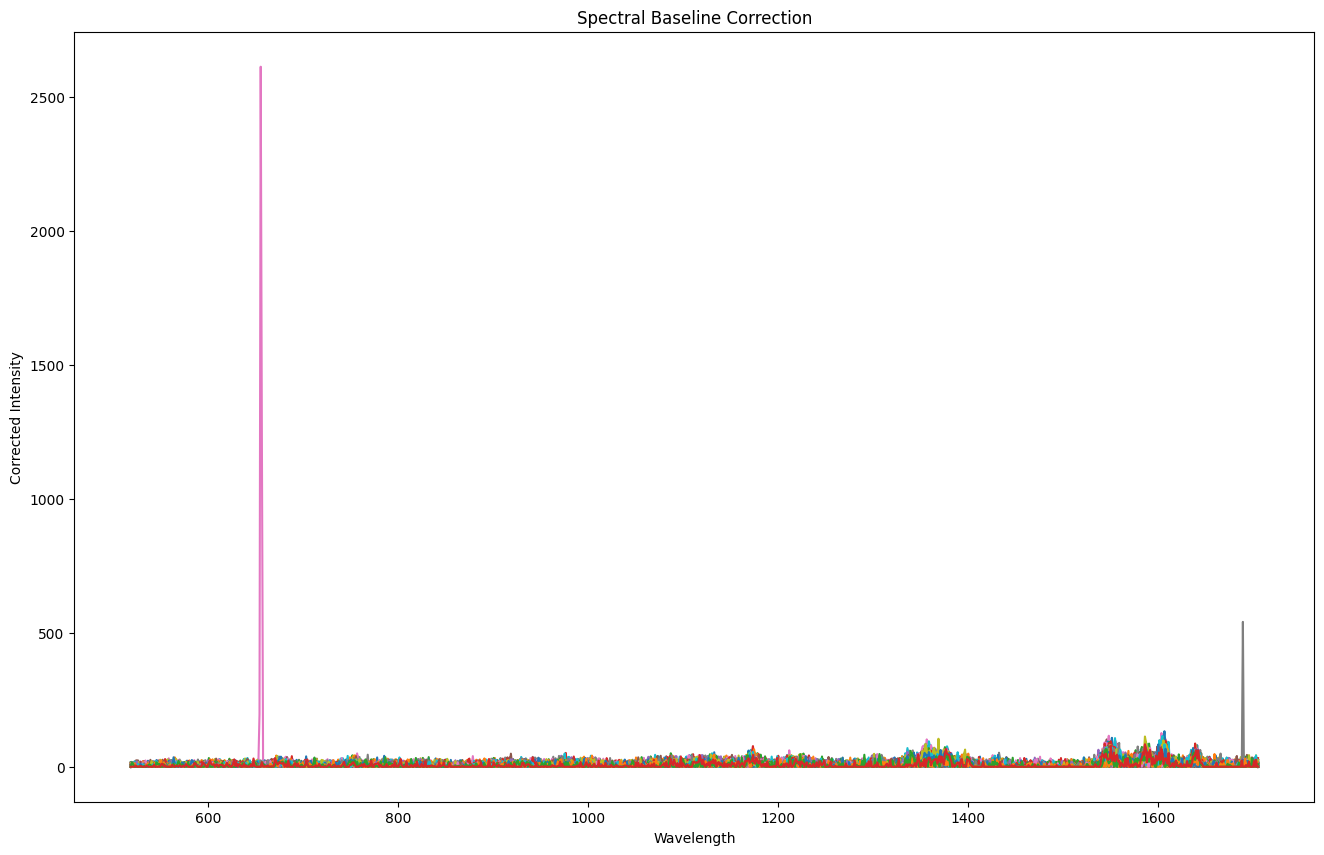

In [3]:
# 2) BASELINE CORRECTION (WHITTAKER SMOOTHER APPROACH)
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define baseline correction function
def raman_baseline_correction(wavenumbers, spectrum, polynomial_order):
    def chebyshev_polynomial(x, *coefficients):
        return np.polynomial.chebyshev.chebval(x, coefficients)

    # Fit Chebyshev polynomial to entire spectrum
    baseline_coefficients, _ = curve_fit(chebyshev_polynomial, wavenumbers, spectrum, p0=np.zeros(polynomial_order + 1))

    # Subtract fitted polynomial from original spectrum
    corrected_baseline = spectrum - chebyshev_polynomial(wavenumbers, *baseline_coefficients)

    return baseline_coefficients, corrected_baseline 

# Load data
df = pd.read_csv('all_spectra_id.csv')

# Initialize an empty list to store DataFrames
dfs = []

# Initialize a counter for generating unique IDs
id_counter = 1

# Perform baseline correction & append to list
for Spectrum_ID in df['Spectrum_ID'].unique():
    # Extract relevant data for current spectrum
    wavenumbers_spectrum = df[df['Spectrum_ID'] == Spectrum_ID]['Wavelength']
    intensity_spectrum = df[df['Spectrum_ID'] == Spectrum_ID]['Intensity']
    
    # Check if data is not empty
    if wavenumbers_spectrum.empty or intensity_spectrum.empty:
        print(f"No data found for spectrum ID: {Spectrum_ID}")
        continue

    # Perform baseline correction for current spectrum
    polynomial_order_spectrum = 5
    baseline_coefficients_spectrum, corrected_baseline_spectrum = raman_baseline_correction(wavenumbers_spectrum, intensity_spectrum, polynomial_order_spectrum)

    # Ensure corrected intensity is non-negative
    corrected_baseline_spectrum = np.maximum(corrected_baseline_spectrum, 0)
    
    # Generate a unique ID for each spectrum
    spectrum_id = f'Spectrum_{id_counter}'
    id_counter += 1

    # Add Spectrum_ID column back to corrected DataFrame
    corrected_baseline_df = pd.DataFrame({'Spectrum_ID': spectrum_id, 'Wavelength': wavenumbers_spectrum, 'Corrected_Intensity': corrected_baseline_spectrum})
    
    # Reorganize columns
    corrected_baseline_df = corrected_baseline_df[['Spectrum_ID', 'Wavelength', 'Corrected_Intensity']]

    # Append corrected spectrum DataFrame to the list
    dfs.append(corrected_baseline_df)

# Concatenate all DataFrames into a single
combined_df = pd.concat(dfs, ignore_index=True)

# Save combined DataFrame in one file
combined_df.to_csv("combined_file.csv", index=False)

# Print first few rows
print(combined_df.head())

# Plot
plt.figure(figsize=(16, 10), dpi=100)

num_spectra_to_plot = 135 
for spectrum_id in combined_df['Spectrum_ID'].unique()[:num_spectra_to_plot]:
    # Extract data for current spectrum
    spectrum_data = combined_df[combined_df['Spectrum_ID'] == spectrum_id]
    wavenumbers = spectrum_data['Wavelength']
    corrected_intensity = spectrum_data['Corrected_Intensity']
    plt.plot(wavenumbers, corrected_intensity, label=f'Spectrum {spectrum_id}')

plt.xlabel('Wavelength')
plt.ylabel('Corrected Intensity')
plt.title('Spectral Baseline Correction')
plt.show()

Loaded combined data:
  Spectrum_ID   Wavelength  Corrected_Intensity
0  Spectrum_1  1705.003906             1.007219
1  Spectrum_1  1703.941406             0.000000
2  Spectrum_1  1702.878906             1.931192
3  Spectrum_1  1701.816406             0.000000
4  Spectrum_1  1700.753906             2.869620

Data information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136010 entries, 0 to 136009
Data columns (total 3 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Spectrum_ID          136010 non-null  object 
 1   Wavelength           136010 non-null  float64
 2   Corrected_Intensity  136010 non-null  float64
dtypes: float64(2), object(1)
memory usage: 3.1+ MB
None

Unique Spectrum_IDs:
['Spectrum_1' 'Spectrum_2' 'Spectrum_3' 'Spectrum_4' 'Spectrum_5'
 'Spectrum_6' 'Spectrum_7' 'Spectrum_8' 'Spectrum_9' 'Spectrum_10'
 'Spectrum_11' 'Spectrum_12' 'Spectrum_13' 'Spectrum_14' 'Spectrum_15'
 'Spectrum_16' 'Spectru

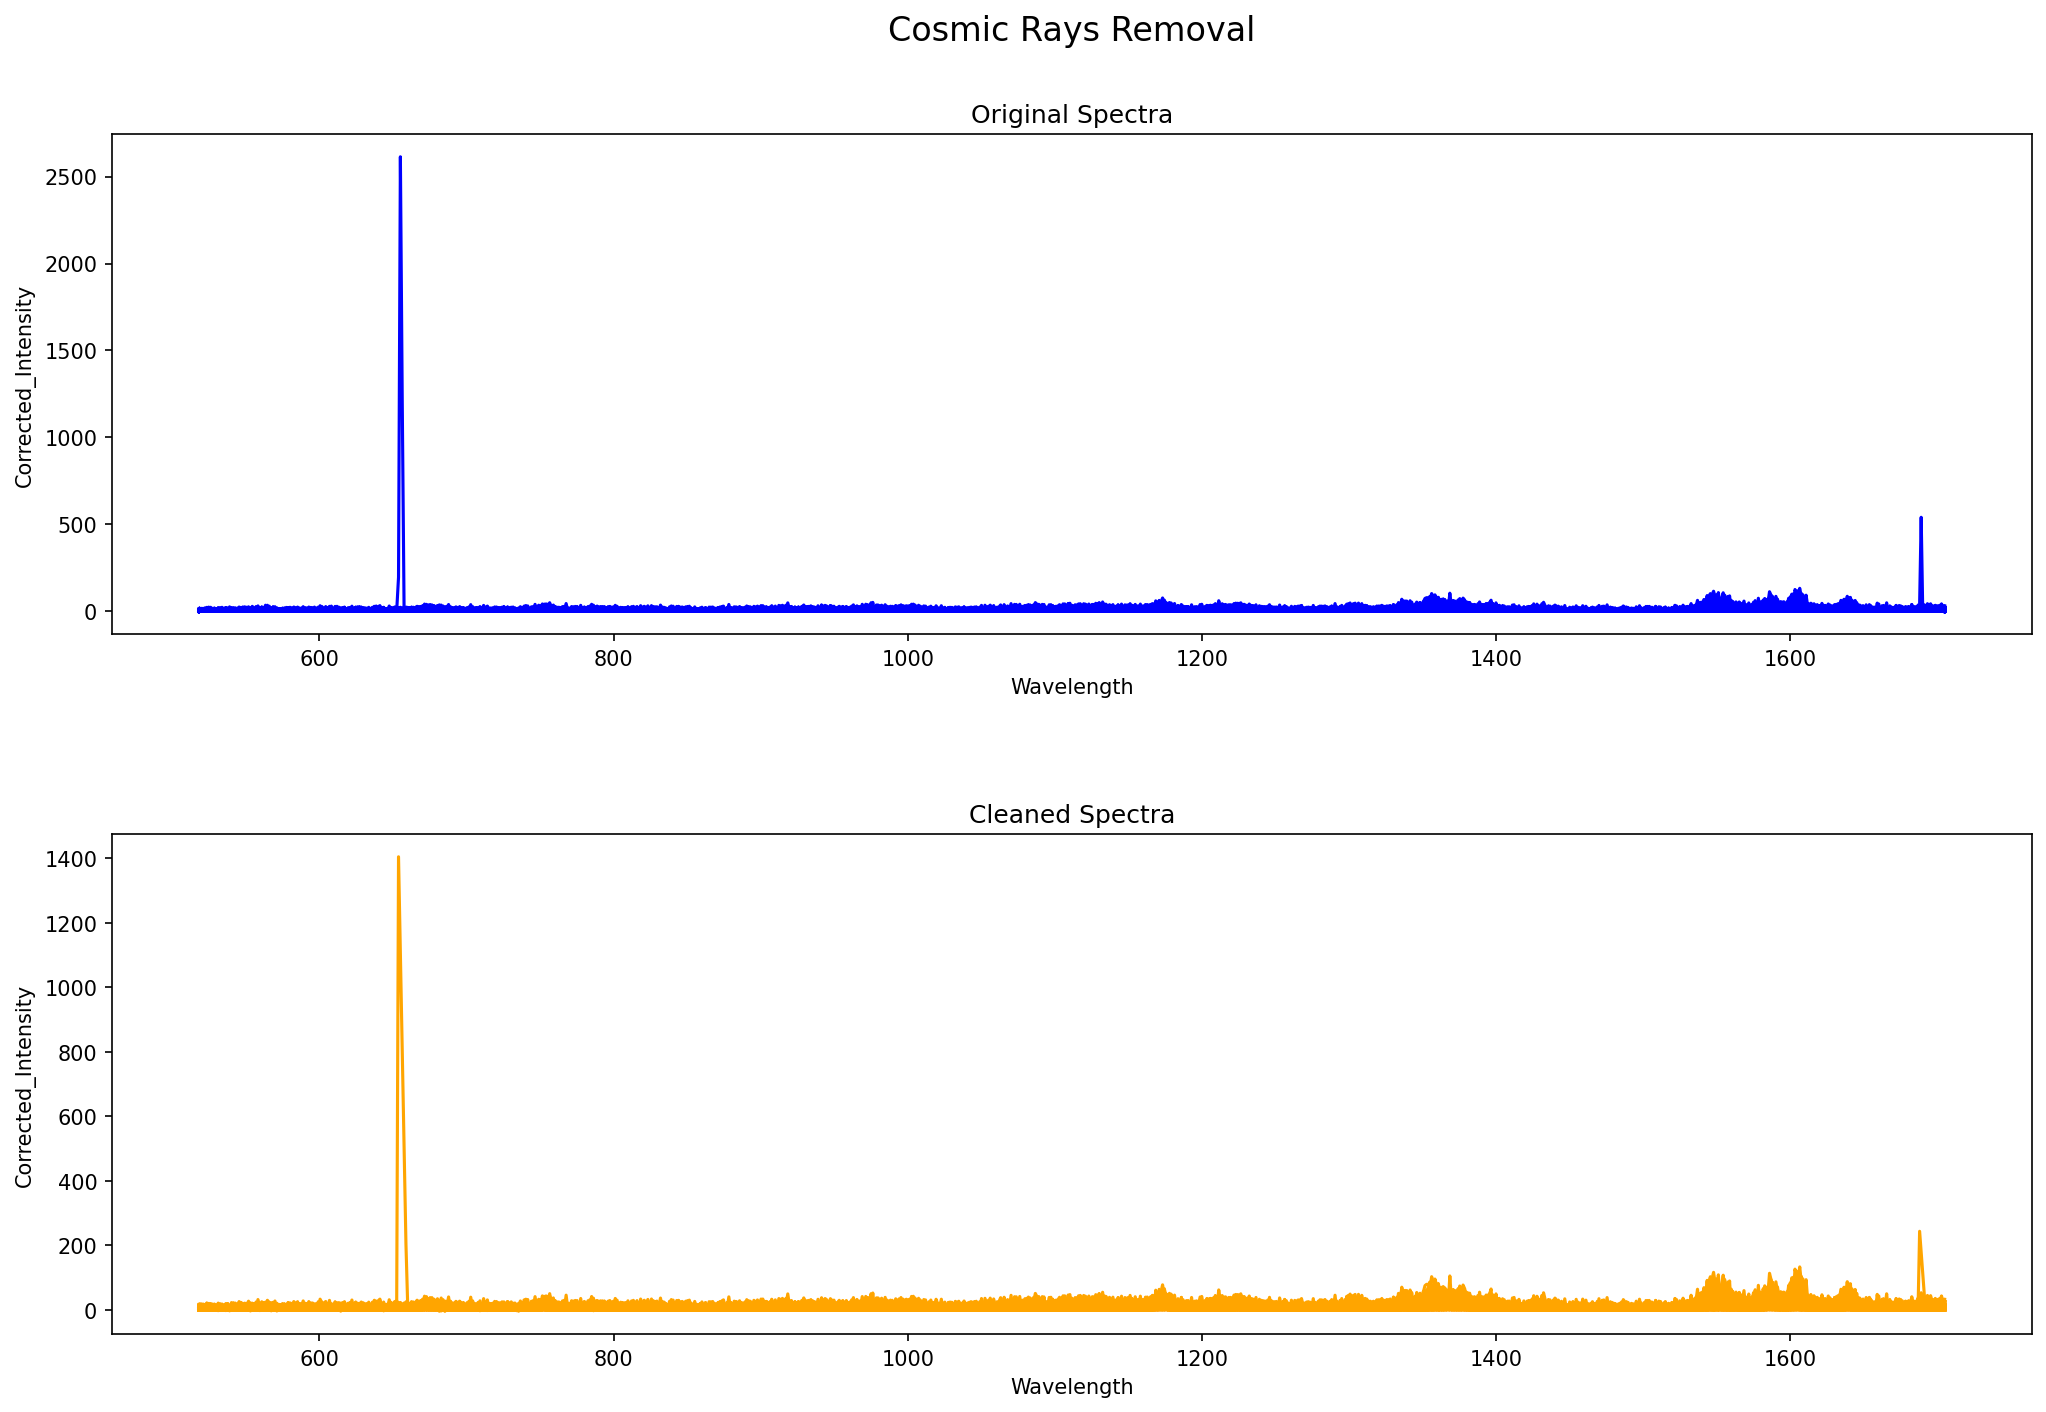

In [4]:
# 3) COSMIC RAYS REMOVAL
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read file
combined_file_path = '/kaggle/working/combined_file.csv'
combined_data = pd.read_csv(combined_file_path)

# 1. Data Loading: verify the file is loaded correctly
print("Loaded combined data:")
print(combined_data.head())

# 2. Data Inspection: verify the structure of loaded data
print("\nData information:")
print(combined_data.info())

# 3. Check enumeration of ID column
print("\nUnique Spectrum_IDs:")
print(combined_data['Spectrum_ID'].unique())

# Define number of spectra
num_spectra = 135

# Initialize a list to store cleaned spectra
cleaned_spectra = []

# 4. Review loop logic
for i in range(num_spectra):
    spectrum_id = f'Spectrum_{i + 1}'
    spectrum_data = combined_data[combined_data['Spectrum_ID'] == spectrum_id]
    
    # 5. Error Handling: check for empty data
    if not spectrum_data.empty:
        try:
            # CLEANING PROCESS
            # A) IDENTIFY COSMIC RAYS POINTS:
            # Calculate second difference of spectrum to accentuate sharp spikes
            first_difference = np.diff(spectrum_data['Corrected_Intensity'], n=1)
            second_difference = np.diff(first_difference, n=1)

            # Estimate threshold for rays detection (proportional to Standard Deviation)
            threshold = - 2 * np.std(second_difference)

            # Identify points where the second difference exceeds the threshold
            cosmic_ray_indices = np.where(second_difference < threshold)[0]

            # B) DETERMINE RANGE OF VALUES:
            # Define start & end values for the window
            for index in cosmic_ray_indices:
                xs = index
                xe = index

                while xs > 0 and second_difference[xs - 1] > 0:
                    xs -= 1

                while xe < len(second_difference) - 1 and second_difference[xe + 1] > 0:
                    xe += 1

            # C) INTERPOLATION:
            # Extract x & y values for interpolation
            x_values = spectrum_data['Wavelength'].values
            y_values = spectrum_data['Corrected_Intensity'].values

            # Adjust x & y values to interpolate within the determined window
            x_values = np.arange(xs, xe + 1)
            y_values = spectrum_data['Corrected_Intensity'].iloc[xs:xe + 1].values

            # Perform polynomial interpolation
            degree = 1
            coefficients = np.polyfit(x_values, y_values, degree)
            interpolated_values = np.polyval(coefficients, x_values)

            # D) REPLACE COSMIC RAY POINTS:
            window_start = max(0, xs)
            window_end = min(len(spectrum_data), xe)

            # Copy original Corrected_Intensity
            cleaned_intensity = spectrum_data['Corrected_Intensity'].copy()
            
            # Replace values within determined window with interpolated values
            cleaned_intensity.iloc[window_start:window_end + 1] = interpolated_values

            # Store cleaned spectrum
            cleaned_spectrum = pd.DataFrame({
                'Wavelength': spectrum_data['Wavelength'],
                'Corrected_Intensity': cleaned_intensity,
                'Spectrum_ID': spectrum_id
            })

            cleaned_spectra.append(cleaned_spectrum)
            
            # Print information: interpolation & cosmic ray replacement
            print(f"Window start: {window_start}, Window end: {window_end}")
            print("Interpolated values:")
            print(interpolated_values)
            
            # Print information: cleaned_spectrum
            print(f"Cleaned Spectrum {i + 1}:")
            print(cleaned_spectrum.head())
            print()

            # Print information: cleaned intensity before & after replacement
            print("Cleaned intensity before replacement:")
            print(spectrum_data['Corrected_Intensity'].iloc[window_start:window_end + 1])
            print("Cleaned intensity after replacement:")
            print(cleaned_spectrum['Corrected_Intensity'].iloc[window_start:window_end + 1])
            
        except Exception as e:
            print(f"Error processing spectrum {spectrum_id}: {e}")
    else:
        print(f"No data for spectrum {spectrum_id}")

# Save cleaned spectra
output_file_path = '/kaggle/working/cleaned_spectra.csv'

# Print information: cleaned spectra
if cleaned_spectra:
    cleaned_data = pd.concat(cleaned_spectra, ignore_index=True)
    cleaned_data.to_csv(output_file_path, index=False)
    print(f"\nCleaned spectra saved to {output_file_path}")
else:
    print("\nNo cleaned spectra to save")
    
#Plot
plt.figure(figsize=(16, 10), dpi=150)
plt.suptitle('Cosmic Rays Removal', fontsize=16)

# Plot original spectra
plt.subplot(2, 1, 1)
for i in range(num_spectra):
    plt.plot(combined_data[combined_data['Spectrum_ID'] == f'Spectrum_{i + 1}']['Wavelength'],
             combined_data[combined_data['Spectrum_ID'] == f'Spectrum_{i + 1}']['Corrected_Intensity'],color="blue",
             label=f'Spectrum {i + 1}')
plt.title('Original Spectra')
plt.xlabel('Wavelength')
plt.ylabel('Corrected_Intensity')

# Plot cleaned spectra
plt.subplot(2, 1, 2)
for i in range(num_spectra):
    if len(cleaned_spectra) > i:
        plt.plot(cleaned_spectra[i]['Wavelength'], cleaned_spectra[i]['Corrected_Intensity'], color='orange',
                 label=f'Spectrum {i + 1}')

plt.title('Cleaned Spectra')
plt.xlabel('Wavelength')
plt.ylabel('Corrected_Intensity')
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4) # adjust margins
plt.show()

Smoothed spectra saved to /kaggle/working/smoothed_spectra.csv
Index(['Spectrum_ID', 'Wavelength', 'Smoothed_Intensity'], dtype='object')


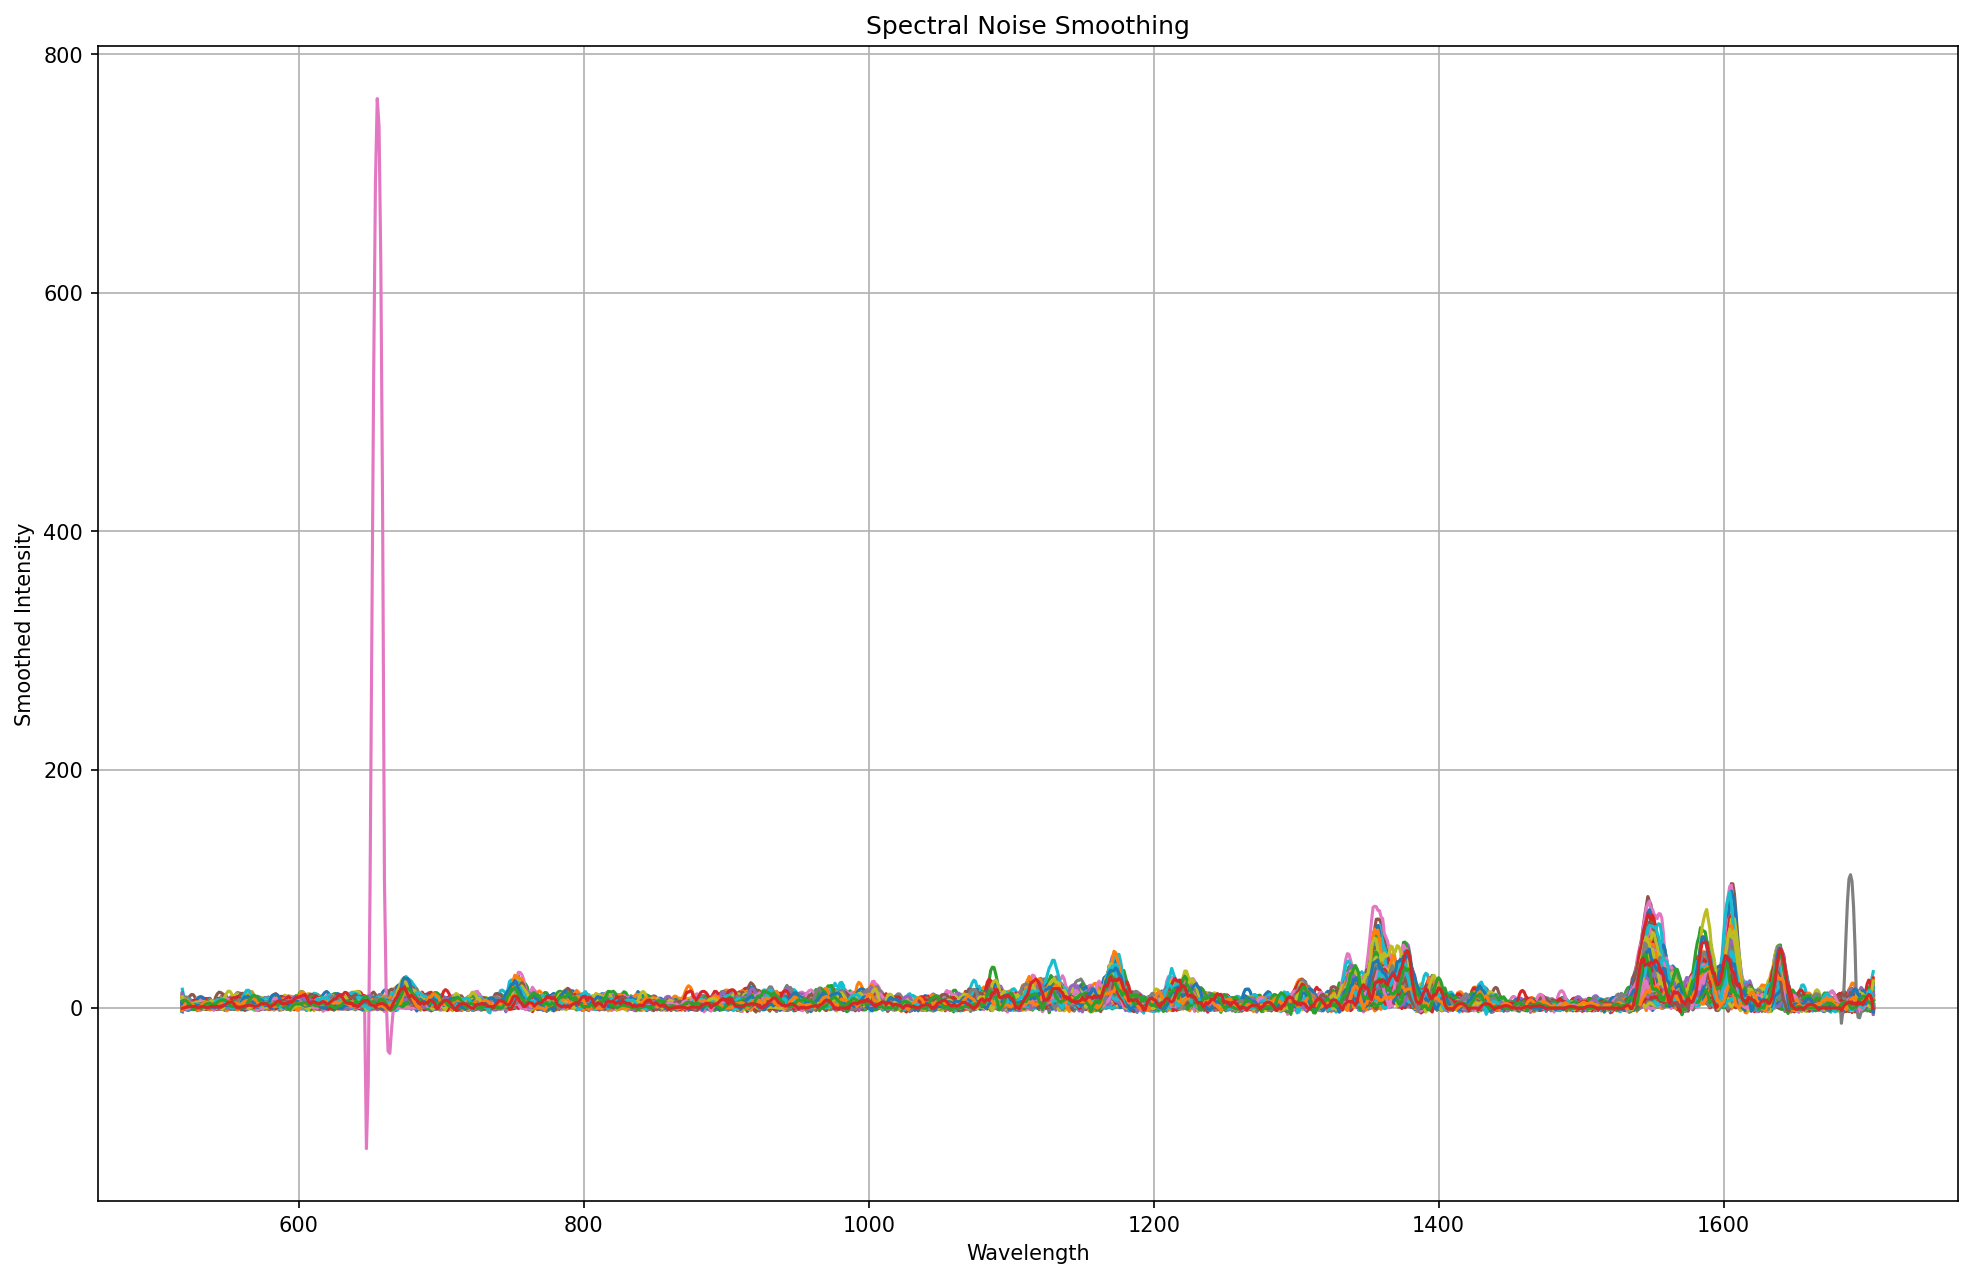

In [5]:
# 4) SMOOTHING NOISE BY SAVITZKY-GOLAY FILTER 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Function to apply Savitzky-Golay filter to intensity data
def savgol_filter_intensity(intensity_data, window_size, poly_order):
    smoothed_intensity = savgol_filter(intensity_data, window_size, poly_order)
    return smoothed_intensity

# Read data
cleaned_spectrum_file = '/kaggle/working/cleaned_spectra.csv'
cleaned_data = pd.read_csv(cleaned_spectrum_file)

# Define parameters for Savitzky-Golay filter
window_size = 11  # window size must be odd
poly_order = 3

# Smooth intensity data for each spectrum
smoothed_spectra = []

# Iterate over unique spectrum IDs
for spectrum_id in cleaned_data['Spectrum_ID'].unique():
    spectrum_data = cleaned_data[cleaned_data['Spectrum_ID'] == spectrum_id].copy()

    # Check if spectrum exists in data
    if not spectrum_data.empty:
        # Convert 'Corrected_Intensity' column to numeric
        spectrum_data['Corrected_Intensity'] = pd.to_numeric(spectrum_data['Corrected_Intensity'], errors='coerce')

        # Drop rows with NaN values (if any)
        spectrum_data = spectrum_data.dropna()
        
        # Check if window size is smaller than or equal to data size
        if window_size <= len(spectrum_data):
            # Apply Savitzky-Golay filter to smooth intensity data
            smoothed_intensity = savgol_filter_intensity(spectrum_data['Corrected_Intensity'], window_size, poly_order)

            # Create a DataFrame with smoothed intensity data along with spectrum ID & wavelengths
            smoothed_spectrum = pd.DataFrame({
                'Spectrum_ID': spectrum_id,
                'Wavelength': spectrum_data['Wavelength'],
                'Smoothed_Intensity': smoothed_intensity
            })

            # Append smoothed spectrum to the list
            smoothed_spectra.append(smoothed_spectrum)
            
# Concatenate into a single DataFrame
if smoothed_spectra:
    smoothed_data = pd.concat(smoothed_spectra, ignore_index=True)

    # Save to a CSV file
    smoothed_data_file = '/kaggle/working/smoothed_spectra.csv'
    smoothed_data.to_csv(smoothed_data_file, index=False)
    
    # Confirming successful saving
    print(f"Smoothed spectra saved to {smoothed_data_file}")
    print(smoothed_data.columns)
else:
    print("No spectra were successfully smoothed.")

# Plot
plt.figure(figsize=(16, 10), dpi=150)

for spectrum_id in smoothed_data['Spectrum_ID'].unique():
    spectrum_data = smoothed_data[smoothed_data['Spectrum_ID'] == spectrum_id]
    plt.plot(spectrum_data['Wavelength'], spectrum_data['Smoothed_Intensity'], label=spectrum_id)

plt.title ('Spectral Noise Smoothing')
plt.xlabel('Wavelength')
plt.ylabel('Smoothed Intensity')
plt.grid(True)
plt.show()

The spectrum with ID Spectrum_97 is the most different from the others.


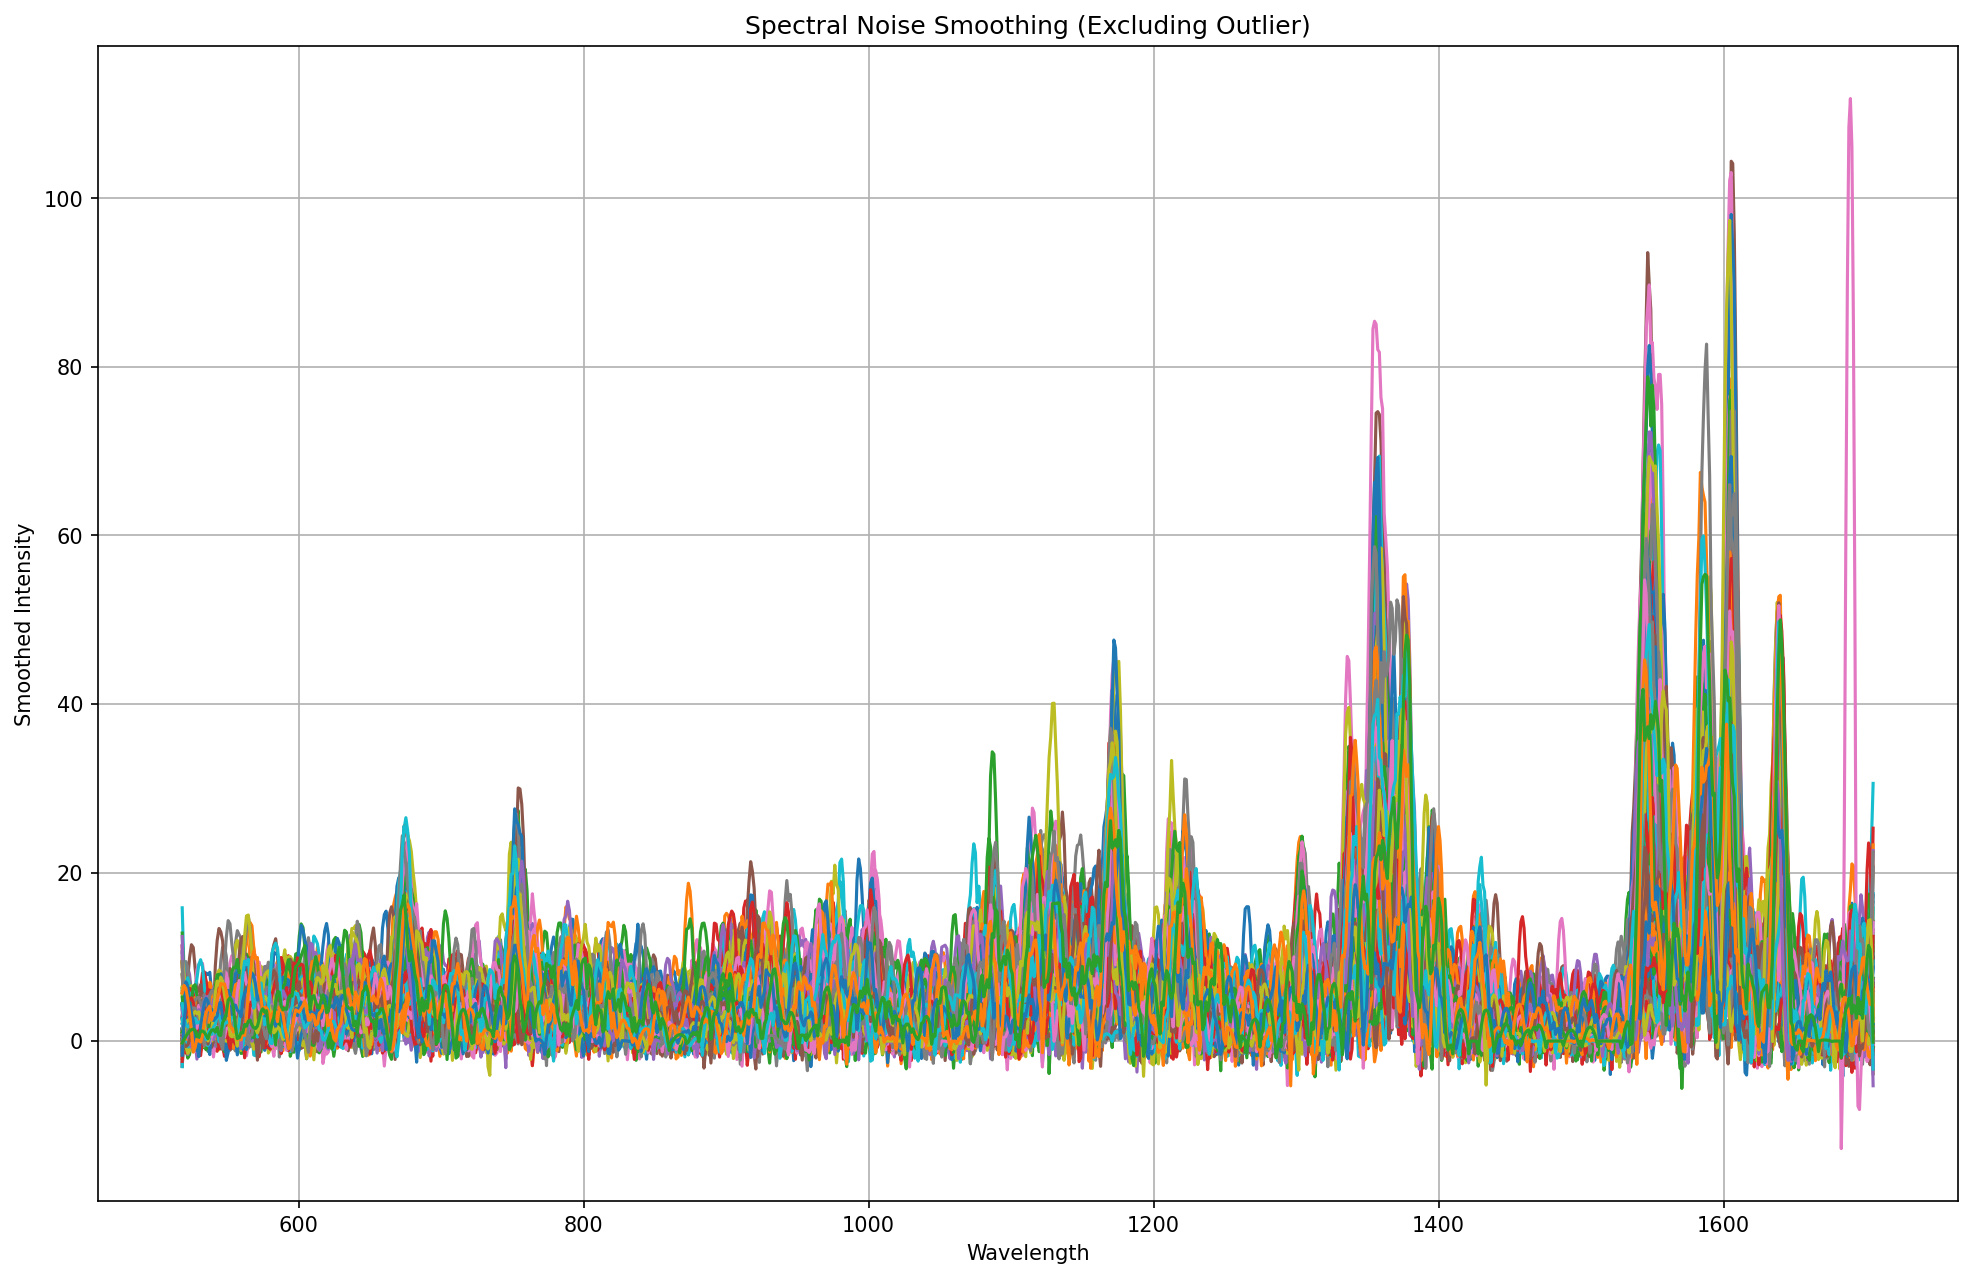

Smoothed spectra without the outlier saved to /kaggle/working/smoothed_spectra_filtered.csv


In [6]:
# Find the different one (outlier)
from scipy.spatial.distance import cdist

# Calculate pairwise distances between spectra based on smoothed intensities
smoothed_intensities = smoothed_data.pivot(index='Wavelength', columns='Spectrum_ID', values='Smoothed_Intensity').fillna(0)
distances = cdist(smoothed_intensities.T, smoothed_intensities.T)

# Compute the average distance of each spectrum to all other spectra
average_distances = distances.mean(axis=1)

# Identify the spectrum with highest average distance
outlier_spectrum_index = average_distances.argmax()
outlier_spectrum_id = smoothed_intensities.columns[outlier_spectrum_index]

print(f"The spectrum with ID {outlier_spectrum_id} is the most different from the others.")

# Filter out the different spectrum
smoothed_data_filtered = smoothed_data[smoothed_data['Spectrum_ID'] != outlier_spectrum_id]

# Plot without the different one
plt.figure(figsize=(16, 10), dpi=150)
for spectrum_id in smoothed_data_filtered['Spectrum_ID'].unique():
    spectrum_data = smoothed_data_filtered[smoothed_data_filtered['Spectrum_ID'] == spectrum_id]
    plt.plot(spectrum_data['Wavelength'], spectrum_data['Smoothed_Intensity'], label=spectrum_id)

plt.title('Spectral Noise Smoothing (Excluding Outlier)')
plt.xlabel('Wavelength')
plt.ylabel('Smoothed Intensity')
plt.grid(True)
plt.show()

# Save new smoothed data without the different
smoothed_data_filtered_file = '/kaggle/working/smoothed_spectra_filtered.csv'
smoothed_data_filtered.to_csv(smoothed_data_filtered_file, index=False)
print(f"Smoothed spectra without the outlier saved to {smoothed_data_filtered_file}")


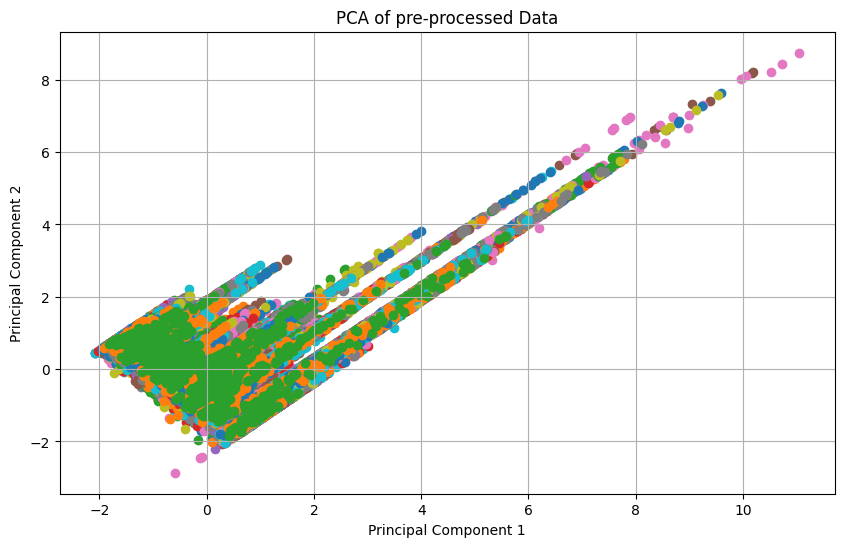

Explained variance ratio: [0.6155975 0.3844025]
Loadings:
                         PC1       PC2
Wavelength          0.707107 -0.707107
Smoothed_Intensity  0.707107  0.707107


In [7]:
# PCA from dataset (smoothed without outlier)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Read smoothed data
smoothed_data_file = '/kaggle/working/smoothed_spectra_filtered.csv'
smoothed_data = pd.read_csv(smoothed_data_file)

# Extract features (wavelengths) & target (smoothed intensity)
X = smoothed_data.drop(columns=['Spectrum_ID']).values
y = smoothed_data['Spectrum_ID'].values

# Standardize data (mean-centered & scaled)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA(n_components=2) 
principal_components = pca.fit_transform(X_scaled)

# Create a DataFrame to hold PCA
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Spectrum_ID'] = y

# Plot the PCA results
plt.figure(figsize=(10, 6))
for spectrum_id in pca_df['Spectrum_ID'].unique():
    spectrum_data = pca_df[pca_df['Spectrum_ID'] == spectrum_id]
    plt.scatter(spectrum_data['PC1'], spectrum_data['PC2'], label=spectrum_id)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of pre-processed Data')
plt.grid(True)
plt.show()

# Analysis & interpretation
print("Explained variance ratio:", pca.explained_variance_ratio_)

# Calculate scores and loadings
scores = pca.transform(X_scaled)
loadings = pca.components_

# Create DataFrame for scores
scores_df = pd.DataFrame(data=scores, columns=['PC1', 'PC2'])
scores_df['Spectrum_ID'] = y

# Interpret loadings
loadings_df = pd.DataFrame(data=loadings.T, index=smoothed_data.drop(columns=['Spectrum_ID']).columns,
                           columns=['PC1', 'PC2'])
print("Loadings:")
print(loadings_df)


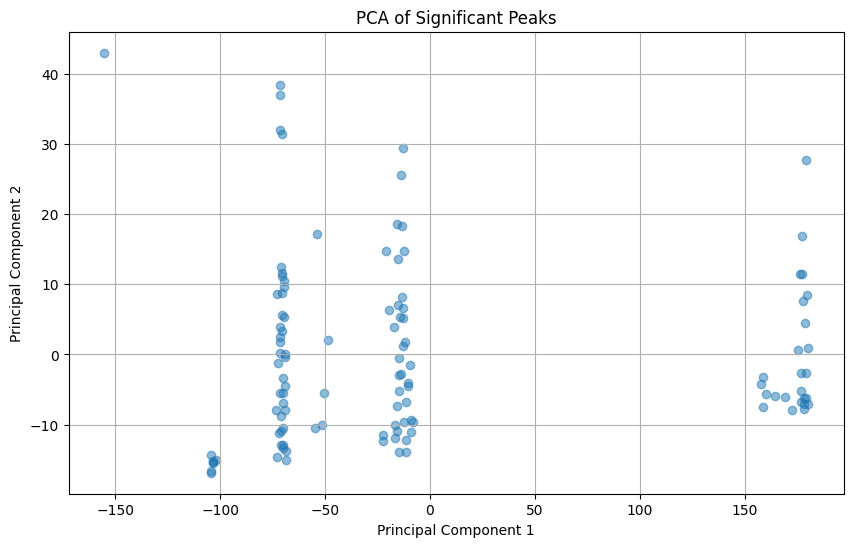

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


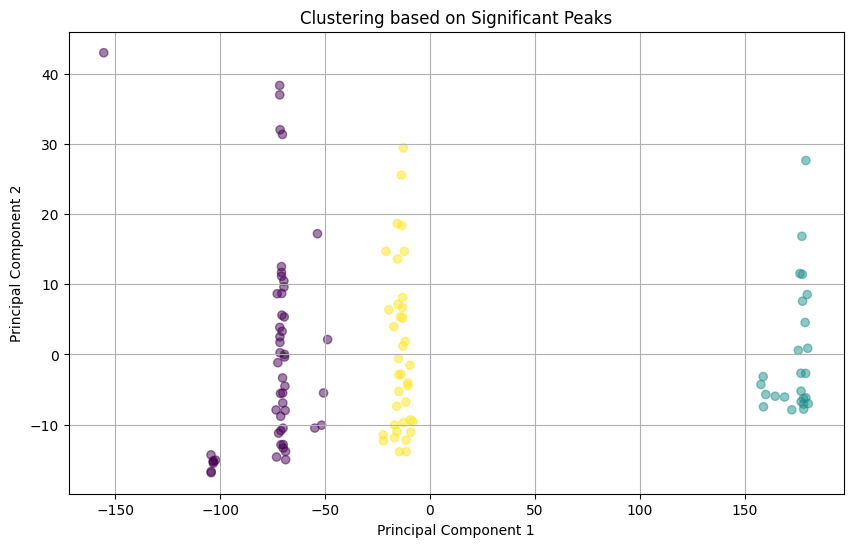

Data with Principal Components and Cluster Labels:
      Spectrum_ID   Wavelength  Intensity         PC1        PC2  \
0      Spectrum_1  1606.482422  69.963363  -71.572213   3.851519   
1      Spectrum_1  1604.322266  71.377041  -69.460025   5.335828   
2      Spectrum_1  1550.070313  58.990943  -14.827899  -5.247535   
3      Spectrum_1  1544.619141  62.534804   -9.496994  -1.525421   
4      Spectrum_1  1362.955078  50.149972  172.477376  -7.891265   
..            ...          ...        ...         ...        ...   
108  Spectrum_129  1588.097656  82.702195  -53.619076  17.192055   
109  Spectrum_129  1370.822266  52.351334  164.541671  -5.950569   
110  Spectrum_129  1366.328125  52.081976  169.042264  -6.071047   
111  Spectrum_131  1585.931641  59.939229  -50.701177  -5.486104   
112  Spectrum_134  1587.015625  55.385039  -51.633852 -10.073670   

     Cluster_Label  
0                0  
1                0  
2                2  
3                2  
4                1  
..    

In [8]:
# PCA of significant peaks
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Read smoothed spectra data
smoothed_data_file = '/kaggle/working/smoothed_spectra_filtered.csv'
smoothed_data = pd.read_csv(smoothed_data_file)

# Define threshold intensity
threshold_intensity = 50

# Initialize lists to store significant peaks
significant_wavelengths = []
significant_intensities = []
significant_spectrum_ids = []

# Iterate over unique spectrum IDs
for spectrum_id in smoothed_data['Spectrum_ID'].unique():
    spectrum_data = smoothed_data[smoothed_data['Spectrum_ID'] == spectrum_id]

    # Find significant peaks for each spectrum
    peaks, _ = find_peaks(spectrum_data['Smoothed_Intensity'], height=threshold_intensity)

    # Append significant peaks & their corresponding data
    for peak in peaks:
        significant_wavelengths.append(spectrum_data['Wavelength'].iloc[peak])
        significant_intensities.append(spectrum_data['Smoothed_Intensity'].iloc[peak])
        significant_spectrum_ids.append(spectrum_id)

# Create DataFrame for significant peaks
significant_peaks_data = pd.DataFrame({
    'Spectrum_ID': significant_spectrum_ids,
    'Wavelength': significant_wavelengths,
    'Intensity': significant_intensities
})

# Perform one-hot encoding for spectrum ID
spectrum_id_encoded = pd.get_dummies(significant_peaks_data['Spectrum_ID'])

# Combine spectrum ID & significant peaks
peaks_encoded = pd.concat([spectrum_id_encoded, significant_peaks_data.drop(columns=['Spectrum_ID'])], axis=1)

# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(peaks_encoded)

# Plot PCA results
plt.figure(figsize=(10, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Significant Peaks')
plt.grid(True)
plt.show()

# Perform clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(principal_components)
labels = kmeans.labels_

# Plot PCA with clustering
plt.figure(figsize=(10, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clustering based on Significant Peaks')
plt.grid(True)
plt.show()

# Combine significant peaks data, PC, & cluster labels
data_with_components = pd.DataFrame({
    'Spectrum_ID': significant_peaks_data['Spectrum_ID'],
    'Wavelength': significant_peaks_data['Wavelength'],
    'Intensity': significant_peaks_data['Intensity'],
    'PC1': principal_components[:, 0],
    'PC2': principal_components[:, 1],
    'Cluster_Label': labels
})

# Print rows of combined DataFrame
print("Data with Principal Components and Cluster Labels:")
print(data_with_components)

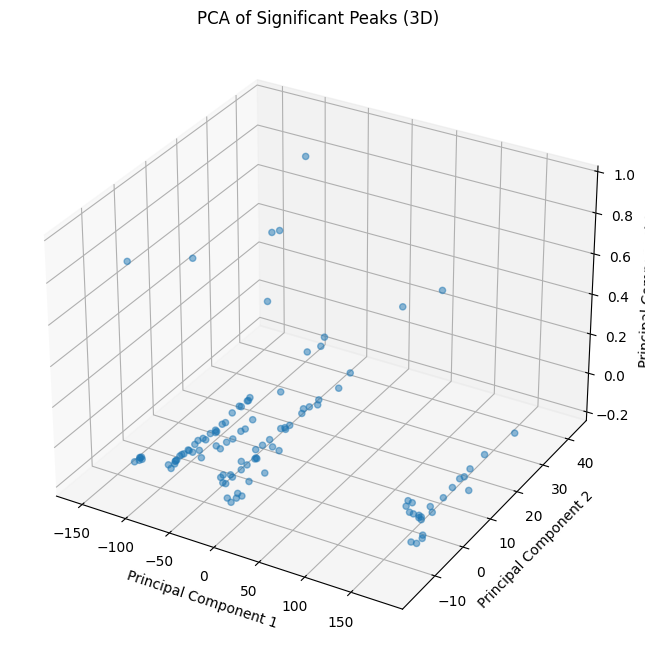

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


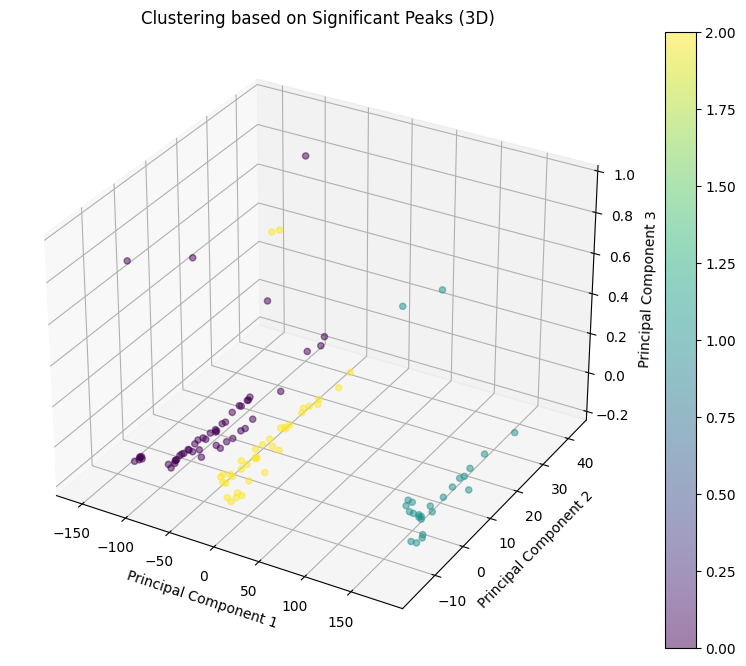

Data with Principal Components and Cluster Labels:
      Spectrum_ID   Wavelength  Intensity         PC1        PC2       PC3  \
0      Spectrum_1  1606.482422  69.963363  -71.572213   3.851519 -0.157754   
1      Spectrum_1  1604.322266  71.377041  -69.460025   5.335828 -0.157928   
2      Spectrum_1  1550.070313  58.990943  -14.827899  -5.247535 -0.156070   
3      Spectrum_1  1544.619141  62.534804   -9.496994  -1.525421 -0.156507   
4      Spectrum_1  1362.955078  50.149972  172.477376  -7.891265 -0.154072   
..            ...          ...        ...         ...        ...       ...   
108  Spectrum_129  1588.097656  82.702195  -53.619076  17.192055 -0.050348   
109  Spectrum_129  1370.822266  52.351334  164.541671  -5.950569 -0.045414   
110  Spectrum_129  1366.328125  52.081976  169.042264  -6.071047 -0.045358   
111  Spectrum_131  1585.931641  59.939229  -50.701177  -5.486104 -0.023121   
112  Spectrum_134  1587.015625  55.385039  -51.633852 -10.073670 -0.022433   

     Cluster

In [9]:
# Perform PCA with 3 principal components
pca = PCA(n_components=3)
principal_components = pca.fit_transform(peaks_encoded)

# Plot PCA with 3 principal components
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(principal_components[:, 0], principal_components[:, 1], principal_components[:, 2], alpha=0.5)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('PCA of Significant Peaks (3D)')
plt.show()

# Perform clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(principal_components)
labels = kmeans.labels_

# Plot PCA with clustering
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(principal_components[:, 0], principal_components[:, 1], principal_components[:, 2], c=labels, cmap='viridis', alpha=0.5)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('Clustering based on Significant Peaks (3D)')
plt.colorbar(scatter)
plt.show()

# Combine significant peaks data, PC, & cluster labels
data_with_components = pd.DataFrame({
    'Spectrum_ID': significant_peaks_data['Spectrum_ID'],
    'Wavelength': significant_peaks_data['Wavelength'],
    'Intensity': significant_peaks_data['Intensity'],
    'PC1': principal_components[:, 0],
    'PC2': principal_components[:, 1],
    'PC3': principal_components[:, 2],
    'Cluster_Label': labels
})

# Print combined DataFrame
print("Data with Principal Components and Cluster Labels:")
print(data_with_components)

In [10]:
# ASSIGN CHARACTERISTICS BY WAVELENGTH VALUES
import csv

# Assigning characteristics based on Spectrum_ID
def assign_characteristics(significant_peaks, database):
    assigned_characteristics = {}
    
    for wavelength, intensity, spectrum_id in significant_peaks:
        # Determine spectrum based on Spectrum_ID
        if spectrum_id not in assigned_characteristics:
            assigned_characteristics[spectrum_id] = []
        
        rounded_wavelength = round(wavelength)
        
        if rounded_wavelength in database:
            characteristics = database[rounded_wavelength]
            assigned_characteristics[spectrum_id].append((rounded_wavelength, intensity, characteristics))
        else:
            assigned_characteristics[spectrum_id].append((rounded_wavelength, intensity, "No data available"))

    return assigned_characteristics

# Peak detection
def detect_peaks(wavelengths, intensities, threshold_intensity):
    significant_peaks = [(wavelengths[i], intensities[i], spectrum_ids[i]) for i in range(len(wavelengths)) if intensities[i] > threshold_intensity]
    return significant_peaks

# Avoiding ignoring data, assigning a range
def load_peak_assignments(filepath):
    assignments = {}
    with open(filepath, newline='') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # skip header row
        for row in reader:
            try:
                # Split range string & take average
                range_values = row[0].split('–')
                if len(range_values) == 2:
                    wavelength = (float(range_values[0].strip()) + float(range_values[1].strip())) / 2
                else:
                    wavelength = float(row[0].strip())
                characteristics = row[1]
                assignments[wavelength] = characteristics
            except ValueError:
                print(f"Ignoring row: {row}. Could not convert wavelength to float.")
    return assignments

# Load spectra data from CSV file
def load_spectra(filepath):
    spectrum_ids = []
    wavelengths = []
    intensities = []
    with open(filepath, newline='') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # skip header row
        for row in reader:
            spectrum_id = row[0]
            wavelength = float(row[1])
            intensity = float(row[2])
            spectrum_ids.append(spectrum_id)
            wavelengths.append(wavelength)
            intensities.append(intensity)
    return wavelengths, intensities, spectrum_ids

# Define pathways to CSV files
peak_assignments_filepath = "/kaggle/input/malariaall-references/Malaria peak assig - all malaria.csv"
spectra_filepath = "/kaggle/working/smoothed_spectra_filtered.csv"

# Load peak assignments & spectra data
peak_assignments = load_peak_assignments(peak_assignments_filepath)
wavelengths, intensities, spectrum_ids = load_spectra(spectra_filepath)

# Define threshold intensity
threshold_intensity = 50 

# Detect peaks
significant_peaks = detect_peaks(wavelengths, intensities, threshold_intensity)

# Assign characteristics
assigned_characteristics = assign_characteristics(significant_peaks, peak_assignments)

# Print assigned characteristics separated by Spectrum ID
print("Assigned characteristics:")
for spectrum_id, characteristics_list in assigned_characteristics.items():
    print(f"{spectrum_id}:")
    for wavelength, intensity, characteristics in characteristics_list:
        if characteristics != "No data available":
            print(f"Wavelength: {wavelength}, Intensity: {intensity}, Characteristics: {characteristics}")
    print()  # Add an empty line between each spectrum's characteristics
            

Assigned characteristics:
Spectrum_1:
Wavelength: 1605, Intensity: 69.75147796054445, Characteristics: oxyHb mode, v19 porphyrin stretching modes, fundamental band
Wavelength: 1552, Intensity: 53.72538885193948, Characteristics: Haemozoin, in-plane stretch of the vinyl group v11, v(CbCb)
Wavelength: 1551, Intensity: 56.572495533505695, Characteristics: u-oxo dimer, v11, v(CbCb)
Wavelength: 1550, Intensity: 58.9909428195466, Characteristics: Haematin, v11, v(CbCb)
Wavelength: 1547, Intensity: 60.169928654299284, Characteristics: oxyHb mode, v11 porphyrin stretching modes, fundamental band
Wavelength: 1357, Intensity: 50.05652053659183, Characteristics: oxyHb mode, v4 porphyrin stretching modes, fundamental band

Spectrum_2:
Wavelength: 1605, Intensity: 77.74395201875764, Characteristics: oxyHb mode, v19 porphyrin stretching modes, fundamental band
Wavelength: 1550, Intensity: 53.40532237639188, Characteristics: Haematin, v11, v(CbCb)
Wavelength: 1547, Intensity: 63.375009806424956, Char